# Model 2 Implementation

Predict the number of times a job will be rejected before it is accepted (the number of rejection events).

In [1]:
# import pkgs
%load_ext autoreload
%autoreload 2
import sys
import utils
import numpy as np
import pandas as pd
#import geopandas as gpd
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 1.1)
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['figure.figsize'] = 14, 10
%config InlineBackend.figure_format = "retina"

import data
import features
import models

# extra functions vasan imported in his notebook
import os
import gmplot
import descartes
import mysql.connector
import geopy
import math
from geopy import distance


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/s2ds/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# get data
data.execute_query_and_save_df('df1_query.sql','df1.feather')
# get weather data
#data.execute_query_and_save_df('weather_query.sql','weather_df.feather')

# read dataframe and call clean function
df_data = pd.read_feather(utils.path_to('data', 'raw', 'df1.feather'))
df_data = data.clean_dataframe_p1(df_data)

# read weather dataframe and call clean function
df_weather = pd.read_feather(utils.path_to('data', 'raw', 'weather_df.feather'))
df_weather = data.clean_weather_df(df_weather)

# get cleaned DataFrame
df = data.clean_merge_and_save('df1.feather','weather_df.feather', 'df_concat.feather')

# load data from data/interim
df = pd.read_feather(utils.path_to('data', 'interim', 'df_concat.feather'))
#df, feature_names  = features.generate_features(df)

Opening database connection
Querying database with query in /Users/samirkhonji/Desktop/S2DS Repository/s2ds/src/data/df1_query.sql
Closing database connection
Writing feather file to /Users/samirkhonji/Desktop/S2DS Repository/s2ds/data/raw/df1.feather

Recoding postcodes in pickup_postcode
Cleaning postcodes in pickup_postcode
Deleting 3 districts not recognized
CRO4LP     1
ECIV8BR    1
LONDON     1
Name: pickup_postcode, dtype: int64
Deleting 12990 districts outside London, listing districts with freq >= 100
RG    2076
HA    1878
KT    1636
GU    1248
EN    1083
SM    1034
RM     738
TW     688
CR     569
UB     284
M      192
TN     176
RH     166
SS     154
DA     152
WD     123
BR     110
IG     104
Name: district, dtype: int64
Deleting 1 unrecognized London outcodes
E215QR    1
Name: pickup_postcode, dtype: int64

Recoding postcodes in delivery_postcode
Cleaning postcodes in delivery_postcode
Deleting 1 districts not recognized
1G118RG    1
Name: delivery_postcode, dtype: int64
D

In [14]:
# Import modules for the chosen regression algorithms
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Import modules for cross-validation and accuracy scoring
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, confusion_matrix, mean_absolute_error

# Run the transform_features function to transform the columns into features that can be interpreted by an algorithm.
df_trans, feature_names = features.generate_features(df)

# Set the features equal to the transformed columns
X = df_trans[feature_names]

# Set the number of rejections before acceoted as the target variable
y = df_trans['rejected_count']

# Split the data into a training set (80%) and testing set (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Timed categorising: earliest_pickup_time
Timed categorising: delivery_deadline
Unchanged features: show_on_board, is_first_war_job, temp, feels_like, humidity, wind_speed, clouds_all, is_daytime
Engineering individual features
Log transforming: distance, initial_time_buffer, estimated_journey_time, courier_earnings_calc, size_min, size_med, size_max, weight, volume, size_min_max
Minimum of initial_time_buffer is less or equal to 0: -12839.0, adding constant of 12840.0 prior to log.
Minimum of courier_earnings_calc is less or equal to 0: -5904.46, adding constant of 5905.46 prior to log.
One hot encoding: is_food, is_fragile, is_liquid, is_not_rotatable, is_glass, is_baked, is_flower, is_alcohol, is_beef, is_pork
One hot encoding: vehicle_type, job_priority, weather_cats, earliest_pickup_time_month, earliest_pickup_time_day, earliest_pickup_time_hour, pickup_zone, delivery_zone
Cyclic encoding: earliest_pickup_time
Cyclic encoding: delivery_deadline


The funciton below will train three different regression models – linear regression, gradient boosted regression trees, and a random forest regressor. It will generate a tuple that stores the R-squared scores and Root Mean Squared Erorrs of each model, for comparison.

In [15]:
def apply_regressors(X_train, y_train, y_test):
    
    # Create list of chosen regression models
    regressors = [linear_model.Lasso(alpha=.5, random_state = 16), GradientBoostingRegressor(random_state= 16),
              RandomForestRegressor(random_state=16, n_estimators=100, max_depth=10)]
    
    # Train each algorithm
    trained_models= [regr.fit(X_train, y_train) for regr in regressors]
    
    # Store (array of) predictions for each algorithm in a list
    model_predictions = [model.predict(X_test) for model in trained_models]
    
    # Store r2 score for each algorithm
    r2_scores = [r2_score(y_test, y_pred) for y_pred in model_predictions]
    
    # Store mse score for each algorithm
    mse_scores = [mean_squared_error(y_test, y_pred) for y_pred in model_predictions]
    
    return zip(r2_scores, mse_scores)

In [16]:
# Apply the function
scores = apply_regressors(X_train, y_train, y_test)

In [17]:
# List used for printing below
regr_names = ['Lasso Regression', 'Gradient Boosted Regression Trees', 'Random Forest']

In [18]:
# Print the 
for score, regr_name in zip(scores, regr_names):
    print('The r2 score for', regr_name, 'is', str(score[0]))
    print('The RMSE score for', regr_name, 'is', str(np.sqrt(score[1])), '\n')

The r2 score for Lasso Regression is 0.0027800583593918793
The RMSE score for Lasso Regression is 4.106716084256675 

The r2 score for Gradient Boosted Regression Trees is 0.11850605813816706
The RMSE score for Gradient Boosted Regression Trees is 3.861080601863307 

The r2 score for Random Forest is 0.13796853899527073
The RMSE score for Random Forest is 3.818218345694272 



The resuts above clearly demonstrate a very poor performance. The R-squared scores are all low, and it is easy to see that a Root Mean Sqiared Error of around 4 is of no predictive value (to determine which jobs should be boosted).

The rejected_count target variable is heavily right-skewed, as was shown by the plot of the distirbution of number of rejections before a job is accepted (in the EDA notebook). This target variable is also "count data", and many distributions of count data are positively skewed with many observations in the data set having a value of 0. The high number of 0’s in the data set prevents the transformation of a skewed distribution into a normal one.  It is quite likely that the regression model will produce negative predicted values, which are theoretically impossible.

An alternative is to use a Poisson regression model or one of its variants. These models have a number of advantages over an ordinary linear regression model, including a skew, discrete distribution, and the restriction of predicted values to non-negative numbers. A Poisson model is similar to an ordinary linear regression, with two exceptions. First, it assumes that the errors follow a Poisson, not a normal, distribution. Second, rather than modeling Y as a linear function of the regression coefficients, it models the natural log of the response variable, ln(Y), as a linear function of the coefficients.

The XGBoost package allows a parameter of objective = "count:poisson", to change the model's distribution to a poisson ditribution. The code below will train a new model based on poisson regression, to see if performance can be improved.

In [19]:
from xgboost import XGBRegressor

In [21]:
label = y_train

In [22]:
xgb = XGBRegressor(objective = "count:poisson", num_boost_round=100000,early_stopping_rounds=5,eval_metric="rmse", random_state = 16)

In [23]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.300000012,
             max_delta_step=0.699999988, max_depth=6, min_child_weight=1,
             missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_boost_round=100000, num_parallel_tree=1,
             objective='count:poisson', random_state=16, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [24]:
y_pred_poisson = xgb.predict(X_test)

In [32]:
print('The r2 score for (gradient boosting) poisson regression is',  str(r2_score(y_test, y_pred_poisson)), '\n')
print('The RMSE score for (gradient boosting) poisson regression is', \
      str(np.sqrt(mean_squared_error(y_test, y_pred_poisson))), '\n')
print('The mean absolute error for (gradient boosting) poisson regression is', str(mean_absolute_error(y_test, y_pred_poisson)))

The r2 score for (gradient boosting) poisson regression is 0.21268980563282536 

The RMSE score for (gradient boosting) poisson regression is 3.648985514172082 

The mean absolute error for (gradient boosting) poisson regression is 1.3910216086878415


As expected, training a poisson regression model improves performance. However, the improvement in performance still is not good enough to demonstrate any potential for value. The model can be improved through hyperparameter tuning (generally yields improvement sof up to 15%) and feature modification, but this is unlikely to improve it enough to be of value. 

To get a bit more insight into how the model predicts, let's plot a data frame comparing the model's predictions against the actual values.

In [35]:
df_compare_poisson = pd.DataFrame()
df_compare_poisson['poisson_model_predictions'] = y_pred_poisson
df_compare_poisson['actual_values'] = np.array(y_test)

In [37]:
df_compare_poisson.head(10)

,poisson_model_predictions,actual_values
0,5.065206,4
1,1.393078,0
2,0.029013,0
3,1.507221,3
4,0.090091,0
5,1.729612,0
6,1.455102,4
7,1.322442,1
8,4.716731,0
9,0.579926,1


In [38]:
# Descriptive statistics for predictions vs actual rejected_count values
df_compare_poisson.describe()

,poisson_model_predictions,actual_values
count,27789.000000,27789.000000
mean,1.220958,1.262766
std,1.662371,4.112510
min,0.003537,0.000000
25%,0.103343,0.000000
50%,0.803561,0.000000
75%,1.594807,1.000000
max,44.573826,110.000000


It can be seen in the data frame above that there is a lot of error in the prediction made by the model. The predictions are much less spread out than the actual values, which shows that the model struggles to use the features to detemine which jobs will take a lot of offers before being accepted.

As a final step, we can produce a plot of predicted values against measured (actual) values to further investigate the model's performance.

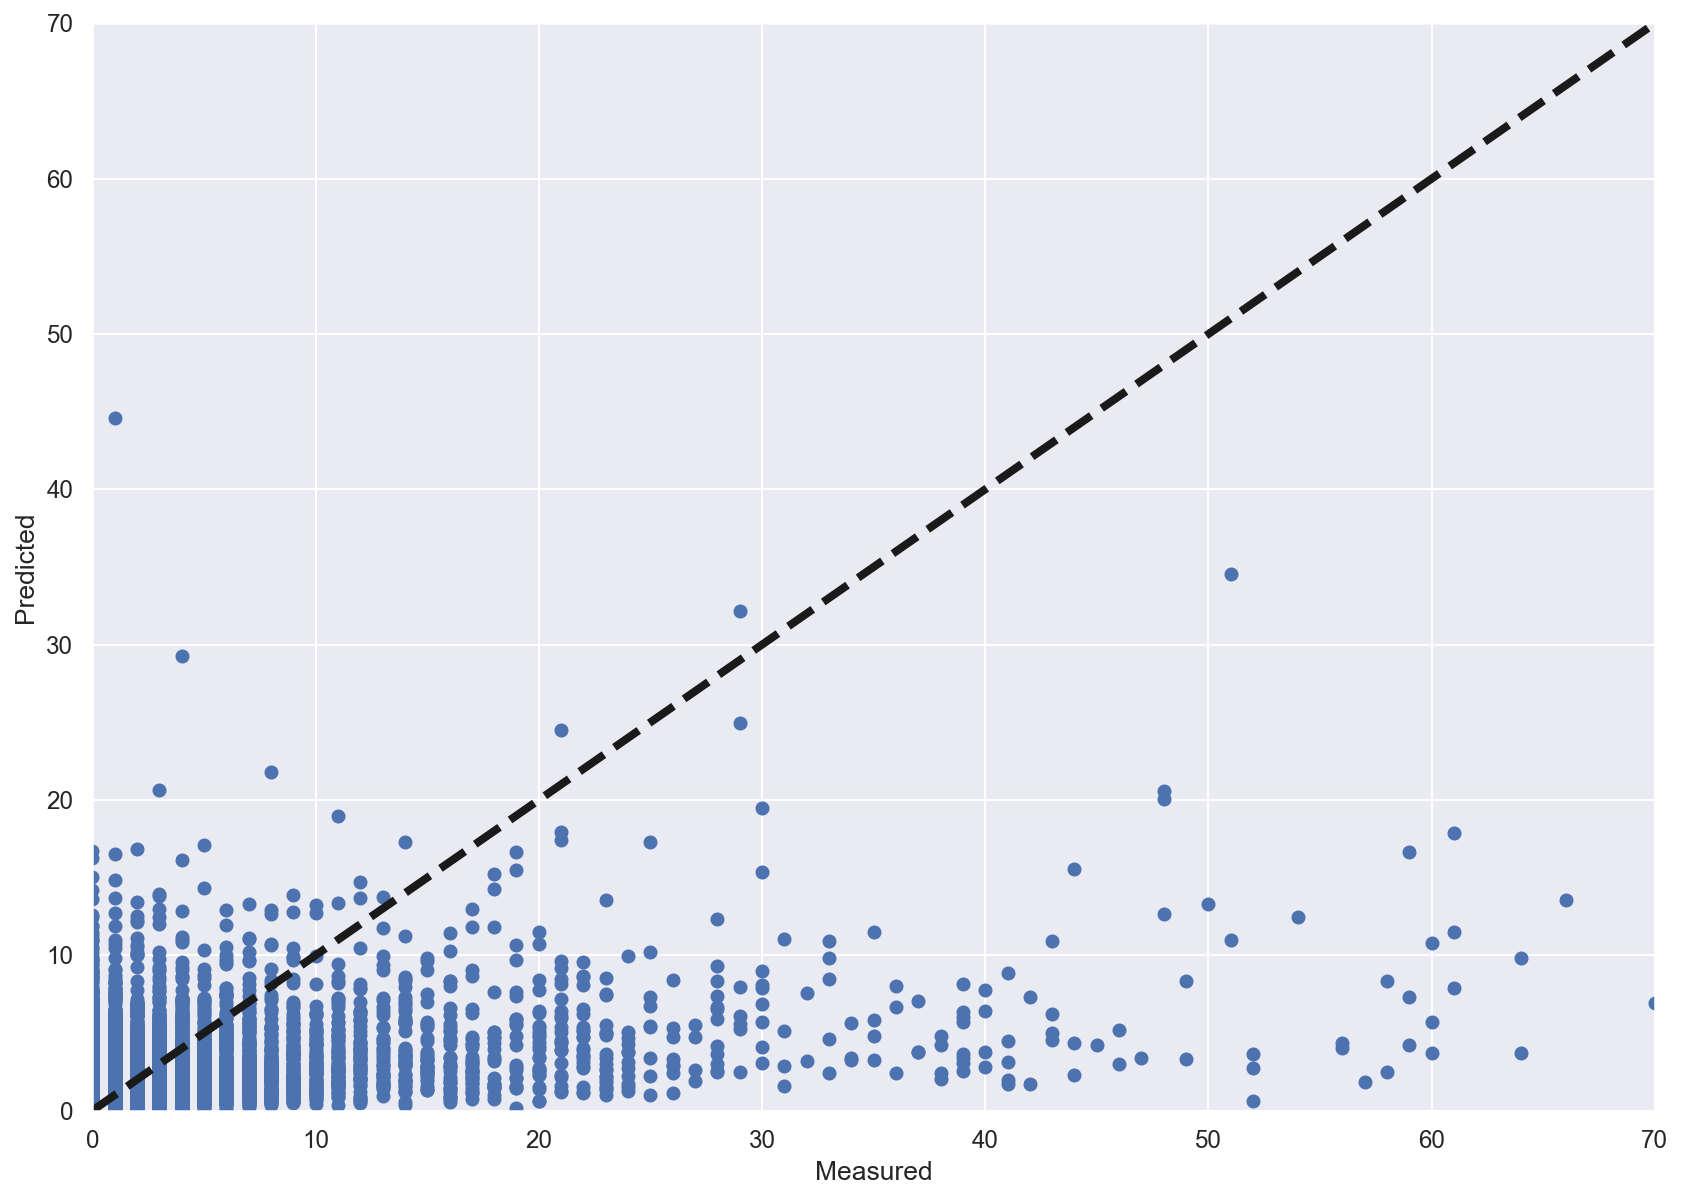

In [42]:
# Plot predicted vs actual values
fig, ax = plt.subplots()
ax.scatter(df_compare_poisson['actual_values'], df_compare_poisson['poisson_model_predictions'])
ax.plot([df_compare_poisson['actual_values'].min(), df_compare_poisson['actual_values'].max()], [df_compare_poisson['actual_values'].min(), df_compare_poisson['actual_values'].max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xlim(0, 70)
ax.set_ylim(0, 70)
plt.show()

In the above plot, a good model should have the points for predicted values and measured values placed symmetrically about the dotted line. This plot visually demonstrates the poor performance of a (poisson) regression model to predict the number of rejections.

Predicting the number of rejections using a regression model is therefore challenging, and such an approach does not appear viable.